In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import AutoTokenizer, BertModel, AdamW;

import torch;
import torch.nn as nn;
import torch.nn.functional as F;
import torch.optim as optim;
from torch.utils.data import Dataset, DataLoader;

In [ ]:
import os;
import os.path;

In [ ]:
import numpy as np;
import matplotlib.pyplot as plt;

import statistics;

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');
print(device);

cuda


In [ ]:
"""
    Using bert model for downstream classification task.
"""

class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super(BERTClassifier, self).__init__();
        self.bert = BertModel.from_pretrained(model_name);

        # freezing model's parameters
        for param in self.bert.parameters():
            param.requires_grad = False;

        self.dropout = nn.Dropout(p=0.2);
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes);

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask);
        output = self.dropout(output.pooler_output);
        output = self.fc(output);
        return output;

In [ ]:
bert_model_name = 'bert-base-uncased';
num_classes = 3;
max_length = 512;
batch_size = 64;
epochs = 3;
learning_rate = 1e-3;

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(bert_model_name);

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
class Dataset(nn.Module):
    def __init__(self,path_x,path_y,max_length):

        self.max_length = max_length;

        if not os.path.exists(path_x):
            raise FileNotFoundError(path_x);
        if not os.path.exists(path_y):
            raise FileNotFoundError(path_y);

        with open(path_x,'r') as f:
            self.x = f.readlines();

        with open(path_y,'r') as f:
            self.y = f.readlines();

        if len(self.x) != len(self.y):
            raise ValueError("x and y must have same length");

    def __len__(self):
        return len(self.x);

    def __getitem__(self,idx):
        x = self.x[idx];
        y = self.y[idx];
        output = tokenizer(x, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt');
        return {
            'input_ids': output['input_ids'].flatten(),
            'attention_mask': output['attention_mask'].flatten(),
            'label' : torch.tensor(int(self.y[idx]))
        };

In [ ]:
train_dataset = Dataset('/content/drive/MyDrive/Data/DATA/rev_trainset_cmb.txt',
                        '/content/drive/MyDrive/Data/DATA/y_train.txt',max_length);

val_dataset = Dataset('/content/drive/MyDrive/Data/DATA/rev_valset_cmb.txt',
                      '/content/drive/MyDrive/Data/DATA/y_val.txt',max_length);

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True);
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True);

In [ ]:
model = BERTClassifier(bert_model_name, num_classes);
model = model.to(device);
optimizer = AdamW(model.parameters(), lr=learning_rate);
criterion = nn.CrossEntropyLoss();

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
store_best_path = "/content/drive/MyDrive/PARAM/";

In [ ]:
epochs = 20;

train_loss = [];
val_loss = [];
train_acc = [];
val_acc = [];

for epoch in range(epochs):

    train_loss_epoch = [];
    val_loss_epoch = [];
    train_acc_epoch = [];
    val_acc_epoch = [];

    model.train();
    for batch in train_loader:
        optimizer.zero_grad();

        input_ids = batch['input_ids'].to(device);
        attention_mask = batch['attention_mask'].to(device);
        y = batch['label'].to(device);

        output = model(input_ids,attention_mask);
        loss = criterion(output,y);
        loss.backward();
        optimizer.step();

        train_loss_epoch.append(loss.item());

        accuracy = torch.argmax(output,dim=-1).view(-1) == y.view(-1);
        train_acc_epoch.append((torch.sum(accuracy) / len(accuracy)).item());


    model.eval();
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device);
            attention_mask = batch['attention_mask'].to(device);
            y = batch['label'].to(device);

            output = model(input_ids,attention_mask);
            loss = criterion(output,y);

            val_loss_epoch.append(loss.item());

            accuracy = torch.argmax(output,dim=-1).view(-1) == y.view(-1);
            val_acc_epoch.append((torch.sum(accuracy) / len(accuracy)).item());


    print(f"Epoch[{epoch}][{epochs}] : Training Loss :{statistics.mean(train_loss_epoch)}, Validation Loss :{statistics.mean(val_loss_epoch)}, \
Training Accuracy :{statistics.mean(train_acc_epoch)}, Validation Accuracy :{statistics.mean(val_acc_epoch)}");

    if len(val_loss) == 0 or statistics.mean(val_loss_epoch) < min(val_loss):
        torch.save(model.state_dict(),store_best_path + 'bert_rouge_embed.pt');

    train_loss.append(statistics.mean(train_loss_epoch));
    val_loss.append(statistics.mean(val_loss_epoch));
    train_acc.append(statistics.mean(train_acc_epoch));
    val_acc.append(statistics.mean(val_acc_epoch));

Epoch[0][20] : Training Loss :1.0618323493003845, Validation Loss :1.0306010337976308, Training Accuracy :0.42625, Validation Accuracy :0.46033653846153844
Epoch[1][20] : Training Loss :1.04412517786026, Validation Loss :1.0375844194338872, Training Accuracy :0.4446875, Validation Accuracy :0.4651442307692308
Epoch[2][20] : Training Loss :1.0255736660957337, Validation Loss :1.024706326998197, Training Accuracy :0.450625, Validation Accuracy :0.4543269230769231
Epoch[3][20] : Training Loss :1.0242096531391143, Validation Loss :1.0204121791399443, Training Accuracy :0.444375, Validation Accuracy :0.43028846153846156
Epoch[4][20] : Training Loss :1.0148211896419526, Validation Loss :1.0052859370525067, Training Accuracy :0.46, Validation Accuracy :0.47475961538461536
Epoch[5][20] : Training Loss :1.032426680326462, Validation Loss :1.083980945440439, Training Accuracy :0.438125, Validation Accuracy :0.4206730769230769
Epoch[6][20] : Training Loss :1.0123685014247894, Validation Loss :1.0

In [ ]:
x = """
Epoch[0][20] : Training Loss :1.0618323493003845, Validation Loss :1.0306010337976308, Training Accuracy :0.42625, Validation Accuracy :0.46033653846153844
Epoch[1][20] : Training Loss :1.04412517786026, Validation Loss :1.0375844194338872, Training Accuracy :0.4446875, Validation Accuracy :0.4651442307692308
Epoch[2][20] : Training Loss :1.0255736660957337, Validation Loss :1.024706326998197, Training Accuracy :0.450625, Validation Accuracy :0.4543269230769231
Epoch[3][20] : Training Loss :1.0242096531391143, Validation Loss :1.0204121791399443, Training Accuracy :0.444375, Validation Accuracy :0.43028846153846156
Epoch[4][20] : Training Loss :1.0148211896419526, Validation Loss :1.0052859370525067, Training Accuracy :0.46, Validation Accuracy :0.47475961538461536
Epoch[5][20] : Training Loss :1.032426680326462, Validation Loss :1.083980945440439, Training Accuracy :0.438125, Validation Accuracy :0.4206730769230769
Epoch[6][20] : Training Loss :1.0123685014247894, Validation Loss :1.016537776360145, Training Accuracy :0.47125, Validation Accuracy :0.43149038461538464
Epoch[7][20] : Training Loss :1.0135259318351746, Validation Loss :1.0109531420927782, Training Accuracy :0.4596875, Validation Accuracy :0.45913461538461536
Epoch[8][20] : Training Loss :1.007585152387619, Validation Loss :0.9975404280882615, Training Accuracy :0.4665625, Validation Accuracy :0.4807692307692308
Epoch[9][20] : Training Loss :1.008954713344574, Validation Loss :1.0010326779805696, Training Accuracy :0.4578125, Validation Accuracy :0.484375
Epoch[10][20] : Training Loss :0.9998794543743134, Validation Loss :1.0097647584401643, Training Accuracy :0.4665625, Validation Accuracy :0.4483173076923077
Epoch[11][20] : Training Loss :1.0018729698657989, Validation Loss :1.0022362149678743, Training Accuracy :0.4734375, Validation Accuracy :0.47836538461538464
Epoch[12][20] : Training Loss :1.022837189435959, Validation Loss :1.0104809861916761, Training Accuracy :0.448125, Validation Accuracy :0.43990384615384615
Epoch[13][20] : Training Loss :1.003867608308792, Validation Loss :1.0182055647556598, Training Accuracy :0.4684375, Validation Accuracy :0.4543269230769231
Epoch[14][20] : Training Loss :1.0080911469459535, Validation Loss :1.0581144461264977, Training Accuracy :0.4671875, Validation Accuracy :0.4182692307692308
Epoch[15][20] : Training Loss :1.0134198951721192, Validation Loss :1.027460400874798, Training Accuracy :0.469375, Validation Accuracy :0.421875
Epoch[16][20] : Training Loss :1.001060951948166, Validation Loss :0.9902775837824895, Training Accuracy :0.4590625, Validation Accuracy :0.4891826923076923
Epoch[17][20] : Training Loss :0.9960604035854339, Validation Loss :0.9939025961435758, Training Accuracy :0.481875, Validation Accuracy :0.48677884615384615
Epoch[18][20] : Training Loss :1.003073308467865, Validation Loss :1.007270987217243, Training Accuracy :0.4903125, Validation Accuracy :0.4855769230769231
Epoch[19][20] : Training Loss :0.9932149124145507, Validation Loss :0.9896006675866934, Training Accuracy :0.484375, Validation Accuracy :0.4963942307692308
""";
pattern = r"Training Loss :(\d+\.\d+), Validation Loss :(\d+\.\d+), Training Accuracy :(\d+\.\d+), Validation Accuracy :(\d+\.\d+)";

In [ ]:
import re;

data = re.findall(pattern,x);
print(data);

[('1.0618323493003845', '1.0306010337976308', '0.42625', '0.46033653846153844'), ('1.04412517786026', '1.0375844194338872', '0.4446875', '0.4651442307692308'), ('1.0255736660957337', '1.024706326998197', '0.450625', '0.4543269230769231'), ('1.0242096531391143', '1.0204121791399443', '0.444375', '0.43028846153846156'), ('1.0148211896419526', '1.0052859370525067', '0.46', '0.47475961538461536'), ('1.032426680326462', '1.083980945440439', '0.438125', '0.4206730769230769'), ('1.0123685014247894', '1.016537776360145', '0.47125', '0.43149038461538464'), ('1.0135259318351746', '1.0109531420927782', '0.4596875', '0.45913461538461536'), ('1.007585152387619', '0.9975404280882615', '0.4665625', '0.4807692307692308'), ('1.008954713344574', '1.0010326779805696', '0.4578125', '0.484375'), ('0.9998794543743134', '1.0097647584401643', '0.4665625', '0.4483173076923077'), ('1.0018729698657989', '1.0022362149678743', '0.4734375', '0.47836538461538464'), ('1.022837189435959', '1.0104809861916761', '0.4481

In [ ]:
train_loss = [float(line[0]) for line in data];
validation_loss = [float(line[1]) for line in data];

train_accuracy = [float(line[2]) for line in data];
validation_accuracy = [float(line[3]) for line in data];

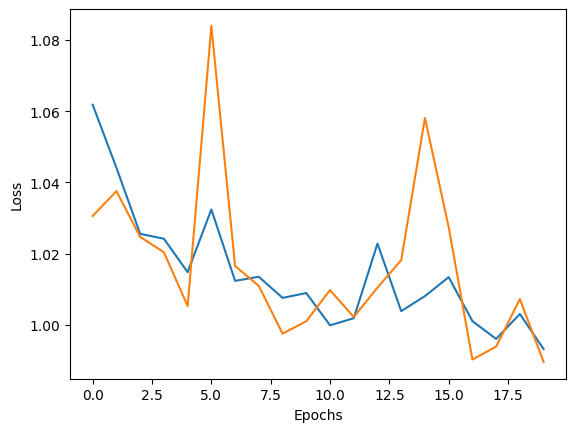

In [ ]:
import matplotlib.pyplot as plt;

plt.plot(train_loss,label="Training loss");
plt.plot(validation_loss,label="Validation loss");
plt.xlabel("Epochs");
plt.ylabel("Loss");

plt.show();

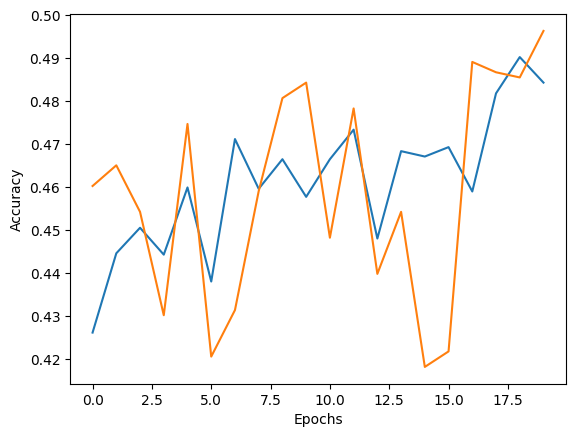

In [ ]:
import matplotlib.pyplot as plt;

plt.plot(train_accuracy,label="Training accuracy");
plt.plot(validation_accuracy,label="Validation accuracy");
plt.xlabel("Epochs");
plt.ylabel("Accuracy");

plt.show();